In [1]:
from mcl import *

In [5]:
class ResetMcl(Mcl):
    def __init__(self,
                         env_map,
                         init_pose,
                         num,
                         motion_noise_stds={'nn': 0.19, 'no': 0.001, 'on': 0.13, 'oo': 0.2},
                         distance_dev_rate=0.14,
                         direction_dev=0.05,
                         alpha_threshold=0.001,
                         expansion_rate=0.2):
        super().__init__(env_map, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold
        self.expansion_rate = expansion_rate
        
    def expansion_resetting(self):
        for p in self.particles:
            p.pose += multivariate_normal(cov=np.eye(3) * (self.expansion_rate ** 2)).rvs()
            p.weight = 1.0 / len(self.particles)
    
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.env_map, self.distance_dev_rate, self.direction_dev)
        
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.expansion_resetting()
        else:
            self.resampling()

<IPython.core.display.Javascript object>


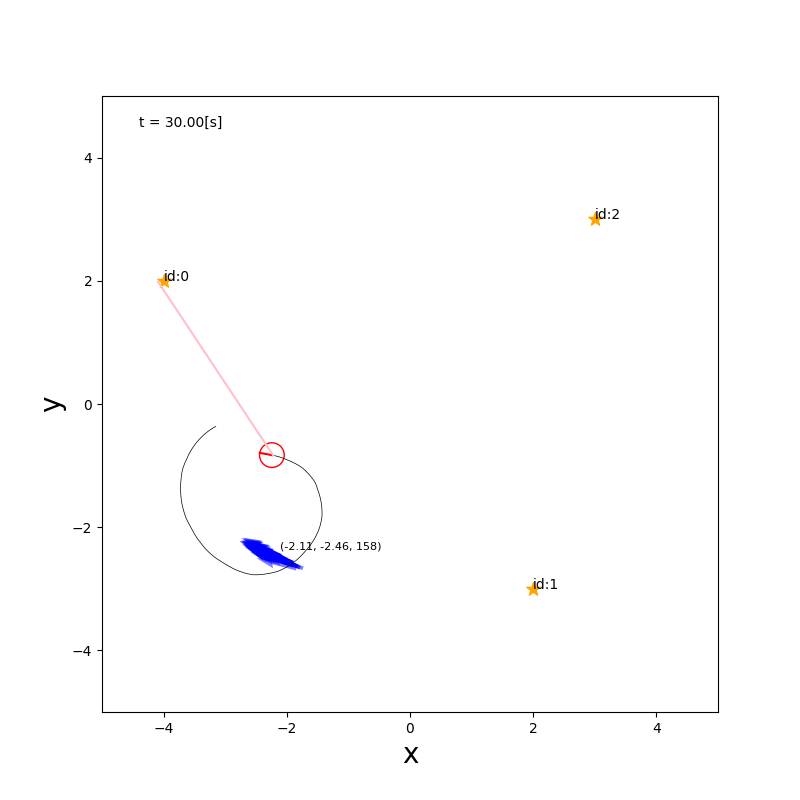

In [6]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    m = Map()
    for lm in [(-4, 2), (2, -3), (3, 3)]:
        m.append_landmark(Landmark(*lm))
    world.append(m)
    
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0 / 180 * math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color='red')
    world.append(r)
    
    world.draw()
    
trial()